<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/DNN_univariate_cases_%2B_deaths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Trends Prediction in Thailand Using Time Series Neural Networks

---


We used convolutional neural network (CNN), recurrent neural networks (RNNs), gated recurrent unit (GRU) and long short-term memory (LSTM) to predict Covid-19 cases and deaths in Thailand, using 14 previous days  to predict the next 1 day. These models particularly deal with time series data.  Our goal was to minimize the mean average percentage error (MAPE) between the actual values and predictions.  



## Data Sources


The Covid-19 data was from https://github.com/CSSEGISandData/COVID-19 by John Hopkins University. The data included both daily confirmed infects and daily confirmed deaths reported by Thailand’s Ministry of Public Health. 




# Import packages

In [1]:
!pip install -U tensorflow-addons
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from keras.layers import LayerNormalization
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical


     |████████████████████████████████| 1.1 MB 13.3 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import data

### Cases

In [2]:
data = read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_cases.csv")

data = pd.DataFrame(data)

# select columns
data = data[["date", "Thailand"]]

# change column name
data = data.rename(columns = {'date':'Date', 'Thailand':'Cases_daily'})

# # change date format
data.Date =  pd.to_datetime(data["Date"])

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["Cases_daily"]] = data[["Cases_daily"]].replace(np.nan, 0)

# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# # reset index
data_i = data.reset_index(drop = True)


In [3]:
data = read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_deaths.csv")

data = pd.DataFrame(data)

# select columns
data = data[["date", "Thailand"]]

# change column name
data = data.rename(columns = {'date':'Date', 'Thailand':'Deaths_daily'})

# # change date format
data.Date =  pd.to_datetime(data["Date"])

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["Deaths_daily"]] = data[["Deaths_daily"]].replace(np.nan, 0)

# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# # reset index
data_d = data.reset_index(drop = True)


Since there were noises in the data, we used moving average to smooth the curve with 3-day window.

In [4]:
# use the previous 14 days to predict the next day
lag = 14
prediction = 1
window = 3 # for moving average
days_predicted = 14

# moving average
data_i['Cases_daily2'] = data_i.Cases_daily
data_i['Cases_daily'] = data_i.Cases_daily.rolling(window).mean()

data_d['Deaths_daily2'] = data_d.Deaths_daily
data_d['Deaths_daily'] = data_d.Deaths_daily.rolling(window).mean()


# remove NaN
data_i.dropna(subset = ["Cases_daily"], inplace=True)
data_d.dropna(subset = ["Deaths_daily"], inplace=True)

data_i = data_i.reset_index(drop = True)
data_d = data_d.reset_index(drop = True)



## Methods

---


The data was available from February 22nd, 2020 to present date. However, the third wave of the epidemic in Thailand started after April 1st, 2021, and the trend started to go upward after June. Thus, we used the data from, June 15th to July 29th, 2021 for our training. There were 31 samples in total for training. Days being predicted were all 14 days before the present date.


For the univariate, we created an input matrix with 14 columns as the previous 14 days input. The number of rows was equal to total samples - 14 days - 1-day prediction + 1 or 31 rows. To demonstrate, the first row would have the 1st to the 14th day. The second row would have the 2nd to the 15th day, and so forth as a rolling window. The output matrix would be the 1 column for 1-day prediction with the same amount of rows as the input matrix. For example, the first row would be the 15th day for the 1-day prediction. Since the neural networks could only work with at least 2 dimensions, we transformed both input and output matrices into 3 dimensions (with 1 as the third dimension).

## Data Preprocessing: Univariate

In [5]:
def split_sequence(sequence, lag):
  x, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + lag
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    x.append(seq_x)
    y.append(seq_y)
  return array(x), array(y)



In [6]:
# confirmed cases
x_i, y_i = split_sequence(data_i.Cases_daily, lag)

# split into training and test sets
index = 30 # 31 days for trainings
X_i_tr = x_i[0:index+1, :]
X_i_ts = x_i[index+1:x_i.shape[0]-days_predicted, :]
X_i_tr = X_i_tr.reshape(X_i_tr.shape[0], X_i_tr.shape[1], 1) # reshape input into 3D
X_i_ts = X_i_ts.reshape(X_i_ts.shape[0], X_i_ts.shape[1], 1)

y_i_tr = y_i[0:index+1]
y_i_ts = y_i[index+1:x_i.shape[0]-days_predicted]
y_i_tr = y_i_tr.reshape(y_i_tr.shape[0], 1, 1) # reshape output into 3D
y_i_ts = y_i_ts.reshape(y_i_ts.shape[0], 1, 1)       

# confirmed deaths
x_d, y_d = split_sequence(data_d.Deaths_daily, lag)

# split
X_d_tr = x_d[0:index+1, :]
X_d_ts = x_d[index+1:x_d.shape[0]-days_predicted, :]
X_d_tr = X_d_tr.reshape(X_d_tr.shape[0], X_d_tr.shape[1], 1)
X_d_ts = X_d_ts.reshape(X_d_ts.shape[0], X_d_ts.shape[1],1)

y_d_tr = y_d[0:index+1]
y_d_ts = y_d[index+1:x_d.shape[0]-days_predicted]
y_d_tr = y_d_tr.reshape(y_d_tr.shape[0], 1, 1)
y_d_ts = y_d_ts.reshape(y_d_ts.shape[0], 1, 1)

# Analysis

---



### Hyperparameters Tuning


Using the training set matrices for confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters, staring from basic architectures. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. In the input layer, we added instance normalization to make all values between 0 and 1. Since we were dealing with some data that we had never seen before and the data seemed to be non-stationary, instance normalization might provide more advantages than typical standardization or normalization. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, 512, and 1024. Similarly, we used the same pool for CNN filter with kernel size of 3, 5 and 7, and pool of 2 and 3. The activation function for this hidden layer was sigmoid. Next, we added another instance normalization. Finally, the output layer contained one node and Linear activation function. Epoch and batch size were 50 and 1, respectively. We used mean squared error (MSE) as our loss function, ADAM optimization and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 


In [ ]:
# Univariate CNN confirmed cases
kernel = [3, 5, 7]
pool = [2]

cnn_i_uni = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr, y_i_tr)
    cnn_i_uni.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr, y_i_tr)
    cnn_i_uni.append(score)

cnn_i_uni = pd.DataFrame(cnn_i_uni).T
cnn_i_uni.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3'] # k3p2: kernel size = 3, pool = 2

filter = 2, kernel size = 3, pooling size = 2: 5.172
filter = 4, kernel size = 3, pooling size = 2: 5.153
filter = 8, kernel size = 3, pooling size = 2: 4.463
filter = 16, kernel size = 3, pooling size = 2: 4.832
filter = 32, kernel size = 3, pooling size = 2: 4.274
filter = 64, kernel size = 3, pooling size = 2: 4.200
filter = 128, kernel size = 3, pooling size = 2: 3.843
filter = 256, kernel size = 3, pooling size = 2: 4.020
filter = 512, kernel size = 3, pooling size = 2: 4.351
filter = 1024, kernel size = 3, pooling size = 2: 4.441
filter = 2, kernel size = 5, pooling size = 2: 5.081
filter = 4, kernel size = 5, pooling size = 2: 5.934
filter = 8, kernel size = 5, pooling size = 2: 5.050
filter = 16, kernel size = 5, pooling size = 2: 3.693
filter = 32, kernel size = 5, pooling size = 2: 4.226
filter = 64, kernel size = 5, pooling size = 2: 3.996
filter = 128, kernel size = 5, pooling size = 2: 3.238
filter = 256, kernel size = 5, pooling size = 2: 3.840
filter = 512, kernel size =

In [ ]:
# Univariate CNN confirmed deaths
pool = [2]

cnn_d_uni = list()

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = list()
    score = run_experiment(filter, kernel_size, pool, X_d_tr, y_d_tr)
    cnn_d_uni.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = list()
    score = run_experiment(filter, kernel_size, pool, X_d_tr, y_d_tr)
    cnn_d_uni.append(score)

cnn_d_uni = pd.DataFrame(cnn_d_uni).T
cnn_d_uni.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 11.430
filter = 4, kernel size = 3, pooling size = 2: 10.756
filter = 8, kernel size = 3, pooling size = 2: 7.691
filter = 16, kernel size = 3, pooling size = 2: 9.191
filter = 32, kernel size = 3, pooling size = 2: 8.271
filter = 64, kernel size = 3, pooling size = 2: 8.443
filter = 128, kernel size = 3, pooling size = 2: 8.257
filter = 256, kernel size = 3, pooling size = 2: 10.281
filter = 512, kernel size = 3, pooling size = 2: 11.570
filter = 1024, kernel size = 3, pooling size = 2: 11.544
filter = 2, kernel size = 5, pooling size = 2: 8.959
filter = 4, kernel size = 5, pooling size = 2: 9.267
filter = 8, kernel size = 5, pooling size = 2: 9.621
filter = 16, kernel size = 5, pooling size = 2: 9.079
filter = 32, kernel size = 5, pooling size = 2: 8.443
filter = 64, kernel size = 5, pooling size = 2: 8.651
filter = 128, kernel size = 5, pooling size = 2: 9.351
filter = 256, kernel size = 5, pooling size = 2: 10.713
filter = 512, kernel 

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# # Univariate LSTM confirmed cases
units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_i_uni = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr, y_i_tr, i)
  lstm_i_uni.append(score)


# Univariate LSTM confirmed deaths

lstm_d_uni = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr, y_d_tr, i)
  lstm_d_uni.append(score)



### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# Univariate GRU confirmed cases

gru_i_uni = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr, y_i_tr, i)
  gru_i_uni.append(score)


# Univariate GRU confirmed deaths

gru_d_uni = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr, y_d_tr, i)
  gru_d_uni.append(score)



### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


# Univariate RNNs confirmed cases

rnn_i_uni = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr, y_i_tr, i)
  rnn_i_uni.append(score)


# Univariate RNNs confirmed deaths

rnn_d_uni = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr, y_d_tr, i)
  rnn_d_uni.append(score)


### Result Table

#### Univariate Confirmed Cases

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_i_uni[0],3), 
                                     round(gru_i_uni[0],3),
                                     round(rnn_i_uni[0],3), 
                                     round(cnn_i_uni.iloc[0,0],3),
                                     round(cnn_i_uni.iloc[0,1],3),
                                     round(cnn_i_uni.iloc[0,2],3),
                                     round(cnn_i_uni.iloc[0,3],3),
                                     round(cnn_i_uni.iloc[0,4],3),
                                     round(cnn_i_uni.iloc[0,5],3)],
                                     [round(lstm_i_uni[1],3), 
                                     round(gru_i_uni[1],3),
                                     round(rnn_i_uni[1],3), 
                                     round(cnn_i_uni.iloc[1,0],3),
                                     round(cnn_i_uni.iloc[1,1],3),
                                     round(cnn_i_uni.iloc[1,2],3),
                                     round(cnn_i_uni.iloc[1,3],3),
                                     round(cnn_i_uni.iloc[1,4],3),
                                     round(cnn_i_uni.iloc[1,5],3)],
                                     [round(lstm_i_uni[2],3), 
                                     round(gru_i_uni[2],3),
                                     round(rnn_i_uni[2],3), 
                                     round(cnn_i_uni.iloc[2,0],3),
                                     round(cnn_i_uni.iloc[2,1],3),
                                     round(cnn_i_uni.iloc[2,2],3),
                                     round(cnn_i_uni.iloc[2,3],3),
                                     round(cnn_i_uni.iloc[2,4],3),
                                     round(cnn_i_uni.iloc[2,5],3)],
                                     [round(lstm_i_uni[3],3), 
                                     round(gru_i_uni[3],3),
                                     round(rnn_i_uni[3],3), 
                                     round(cnn_i_uni.iloc[3,0],3),
                                     round(cnn_i_uni.iloc[3,1],3),
                                     round(cnn_i_uni.iloc[3,2],3),
                                     round(cnn_i_uni.iloc[3,3],3),
                                     round(cnn_i_uni.iloc[3,4],3),
                                     round(cnn_i_uni.iloc[3,5],3)],
                                     [round(lstm_i_uni[4],3), 
                                     round(gru_i_uni[4],3),
                                     round(rnn_i_uni[4],3), 
                                     round(cnn_i_uni.iloc[4,0],3),
                                     round(cnn_i_uni.iloc[4,1],3),
                                     round(cnn_i_uni.iloc[4,2],3),
                                     round(cnn_i_uni.iloc[4,3],3),
                                     round(cnn_i_uni.iloc[4,4],3),
                                     round(cnn_i_uni.iloc[4,5],3)],
                                     [round(lstm_i_uni[5],3), 
                                     round(gru_i_uni[5],3),
                                     round(rnn_i_uni[5],3), 
                                     round(cnn_i_uni.iloc[5,0],3),
                                     round(cnn_i_uni.iloc[5,1],3),
                                     round(cnn_i_uni.iloc[5,2],3),
                                     round(cnn_i_uni.iloc[5,3],3),
                                     round(cnn_i_uni.iloc[5,4],3),
                                     round(cnn_i_uni.iloc[5,5],3)],
                                     [round(lstm_i_uni[6],3), 
                                     round(gru_i_uni[6],3),
                                     round(rnn_i_uni[6],3), 
                                     round(cnn_i_uni.iloc[6,0],3),
                                     round(cnn_i_uni.iloc[6,1],3),
                                     round(cnn_i_uni.iloc[6,2],3),
                                     round(cnn_i_uni.iloc[6,3],3),
                                     round(cnn_i_uni.iloc[6,4],3),
                                     round(cnn_i_uni.iloc[6,5],3)],
                                     [round(lstm_i_uni[7],3), 
                                     round(gru_i_uni[7],3),
                                     round(rnn_i_uni[7],3), 
                                     round(cnn_i_uni.iloc[7,0],3),
                                     round(cnn_i_uni.iloc[7,1],3),
                                     round(cnn_i_uni.iloc[7,2],3),
                                     round(cnn_i_uni.iloc[7,3],3),
                                     round(cnn_i_uni.iloc[7,4],3),
                                     round(cnn_i_uni.iloc[7,5],3)],
                                     [round(lstm_i_uni[8],3), 
                                     round(gru_i_uni[8],3),
                                     round(rnn_i_uni[8],3), 
                                     round(cnn_i_uni.iloc[8,0],3),
                                     round(cnn_i_uni.iloc[8,1],3),
                                     round(cnn_i_uni.iloc[8,2],3),
                                     round(cnn_i_uni.iloc[8,3],3),
                                     round(cnn_i_uni.iloc[8,4],3),
                                     round(cnn_i_uni.iloc[8,5],3)],
                                     [round(lstm_i_uni[9],3), 
                                     round(gru_i_uni[9],3),
                                     round(rnn_i_uni[9],3), 
                                     round(cnn_i_uni.iloc[9,0],3),
                                     round(cnn_i_uni.iloc[9,1],3),
                                     round(cnn_i_uni.iloc[9,2],3),
                                     round(cnn_i_uni.iloc[9,3],3),
                                     round(cnn_i_uni.iloc[9,4],3),
                                     round(cnn_i_uni.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Univariate Confirmed Cases",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

#### Univariate Confirmed Deaths

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes','4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_d_uni[0],3), 
                                     round(gru_d_uni[0],3),
                                     round(rnn_d_uni[0],3), 
                                     round(cnn_d_uni.iloc[0,0],3),
                                     round(cnn_d_uni.iloc[0,1],3),
                                     round(cnn_d_uni.iloc[0,2],3),
                                     round(cnn_d_uni.iloc[0,3],3),
                                     round(cnn_d_uni.iloc[0,4],3),
                                     round(cnn_d_uni.iloc[0,5],3)],
                                     [round(lstm_d_uni[1],3), 
                                     round(gru_d_uni[1],3),
                                     round(rnn_d_uni[1],3), 
                                     round(cnn_d_uni.iloc[1,0],3),
                                     round(cnn_d_uni.iloc[1,1],3),
                                     round(cnn_d_uni.iloc[1,2],3),
                                     round(cnn_d_uni.iloc[1,3],3),
                                     round(cnn_d_uni.iloc[1,4],3),
                                     round(cnn_d_uni.iloc[1,5],3)],
                                     [round(lstm_d_uni[2],3), 
                                     round(gru_d_uni[2],3),
                                     round(rnn_d_uni[2],3), 
                                     round(cnn_d_uni.iloc[2,0],3),
                                     round(cnn_d_uni.iloc[2,1],3),
                                     round(cnn_d_uni.iloc[2,2],3),
                                     round(cnn_d_uni.iloc[2,3],3),
                                     round(cnn_d_uni.iloc[2,4],3),
                                     round(cnn_d_uni.iloc[2,5],3)],
                                     [round(lstm_d_uni[3],3), 
                                     round(gru_d_uni[3],3),
                                     round(rnn_d_uni[3],3), 
                                     round(cnn_d_uni.iloc[3,0],3),
                                     round(cnn_d_uni.iloc[3,1],3),
                                     round(cnn_d_uni.iloc[3,2],3),
                                     round(cnn_d_uni.iloc[3,3],3),
                                     round(cnn_d_uni.iloc[3,4],3),
                                     round(cnn_d_uni.iloc[3,5],3)],
                                     [round(lstm_d_uni[4],3), 
                                     round(gru_d_uni[4],3),
                                     round(rnn_d_uni[4],3), 
                                     round(cnn_d_uni.iloc[4,0],3),
                                     round(cnn_d_uni.iloc[4,1],3),
                                     round(cnn_d_uni.iloc[4,2],3),
                                     round(cnn_d_uni.iloc[4,3],3),
                                     round(cnn_d_uni.iloc[4,4],3),
                                     round(cnn_d_uni.iloc[4,5],3)],
                                     [round(lstm_d_uni[5],3), 
                                     round(gru_d_uni[5],3),
                                     round(rnn_d_uni[5],3), 
                                     round(cnn_d_uni.iloc[5,0],3),
                                     round(cnn_d_uni.iloc[5,1],3),
                                     round(cnn_d_uni.iloc[5,2],3),
                                     round(cnn_d_uni.iloc[5,3],3),
                                     round(cnn_d_uni.iloc[5,4],3),
                                     round(cnn_d_uni.iloc[5,5],3)],
                                     [round(lstm_d_uni[6],3), 
                                     round(gru_d_uni[6],3),
                                     round(rnn_d_uni[6],3), 
                                     round(cnn_d_uni.iloc[6,0],3),
                                     round(cnn_d_uni.iloc[6,1],3),
                                     round(cnn_d_uni.iloc[6,2],3),
                                     round(cnn_d_uni.iloc[6,3],3),
                                     round(cnn_d_uni.iloc[6,4],3),
                                     round(cnn_d_uni.iloc[6,5],3)],
                                     [round(lstm_d_uni[7],3), 
                                     round(gru_d_uni[7],3),
                                     round(rnn_d_uni[7],3), 
                                     round(cnn_d_uni.iloc[7,0],3),
                                     round(cnn_d_uni.iloc[7,1],3),
                                     round(cnn_d_uni.iloc[7,2],3),
                                     round(cnn_d_uni.iloc[7,3],3),
                                     round(cnn_d_uni.iloc[7,4],3),
                                     round(cnn_d_uni.iloc[7,5],3)],
                                     [round(lstm_d_uni[8],3), 
                                     round(gru_d_uni[8],3),
                                     round(rnn_d_uni[8],3), 
                                     round(cnn_d_uni.iloc[8,0],3),
                                     round(cnn_d_uni.iloc[8,1],3),
                                     round(cnn_d_uni.iloc[8,2],3),
                                     round(cnn_d_uni.iloc[8,3],3),
                                     round(cnn_d_uni.iloc[8,4],3),
                                     round(cnn_d_uni.iloc[8,5],3)],
                                     [round(lstm_d_uni[9],3), 
                                     round(gru_d_uni[9],3),
                                     round(rnn_d_uni[9],3), 
                                     round(cnn_d_uni.iloc[9,0],3),
                                     round(cnn_d_uni.iloc[9,1],3),
                                     round(cnn_d_uni.iloc[9,2],3),
                                     round(cnn_d_uni.iloc[9,3],3),
                                     round(cnn_d_uni.iloc[9,4],3),
                                     round(cnn_d_uni.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right','right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Univariate Confirmed Deaths",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

# Training and Validation

---

After models were selected, using the training data set, we adjusted and trained the models to get the prediction with the lowest MAPE. We, then, used test samples for model validations and combined predicted values from both training and test sets together. This was only for illustration purpose.


### Univariate Confirmed Cases

In [7]:
seed(1)
tensorflow.random.set_seed(1)

model_uni_i = Sequential()
model_uni_i.add(SimpleRNN(units = 1024, activation='relu', input_shape=(X_d_tr.shape[1], X_d_tr.shape[2])))
model_uni_i.add(Dense(1, activation = "linear"))
model_uni_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_uni_i.fit(X_i_tr, y_i_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_uni_i1 = model_uni_i.evaluate(X_i_tr, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_uni_i1[1])

scores_uni_i = model_uni_i.evaluate(X_i_ts, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_uni_i[1])

MAPE: training =  2.715256690979004
MAPE: test =  5.132777214050293


In [8]:
# make a prediction
# training set
y_uni_i_tr = pd.DataFrame(model_uni_i.predict(X_i_tr))

# test set
y_uni_i_ts = pd.DataFrame(model_uni_i.predict(X_i_ts))

# combine training and test predictions
y_uni_i_total = pd.concat([y_uni_i_tr, y_uni_i_ts], ignore_index=True)


### Univariate Confirmed Deaths

In [9]:
seed(1)
tensorflow.random.set_seed(1)

model_uni_d = Sequential()
model_uni_d.add(LSTM(32, activation='relu', input_shape=(X_d_tr.shape[1], X_d_tr.shape[2])))
# model_uni_d.add(Dense(2, activation = "relu"))
model_uni_d.add(Dense(1, activation = "linear"))
model_uni_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_uni_d.fit(X_d_tr, y_d_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_uni_d1 = model_uni_d.evaluate(X_d_tr, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_uni_d1[1])

scores_uni_d = model_uni_d.evaluate(X_d_ts, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_uni_d[1])

MAPE: training =  5.386639595031738
MAPE: test =  51.98362731933594


In [10]:
# make a prediction
# training set
y_uni_d_tr = pd.DataFrame(model_uni_d.predict(X_d_tr))

# test set
y_uni_d_ts = pd.DataFrame(model_uni_d.predict(X_d_ts))

# combine training and test predictions
y_uni_d_total = pd.concat([y_uni_d_tr, y_uni_d_ts], ignore_index=True)


The best models for confirmed cases was RNNs with 1024 nodes and ReLu activation function and for confirmed deaths was LSTM with 32 nodes and ReLu activation function. 

In [11]:
uni_in = "RNNs"
uni_de = "LSTM"


### Plots

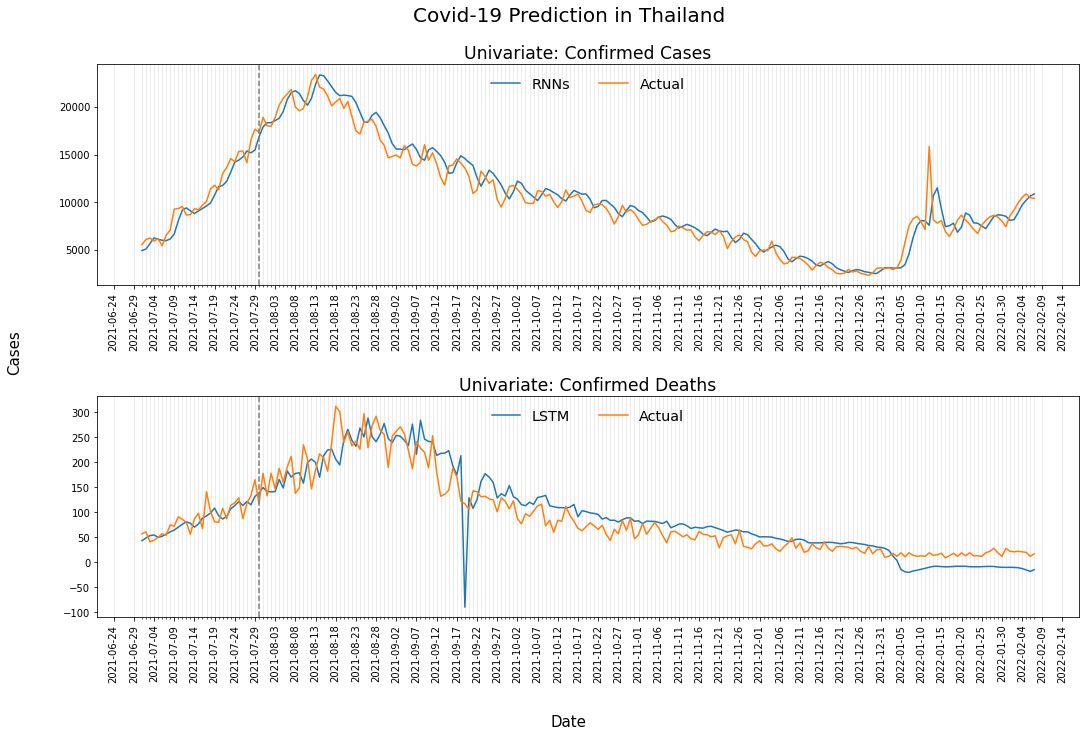

In [12]:
infect = pd.concat([y_uni_i_total,
                   data_i.Cases_daily2.iloc[lag: lag + len(y_uni_i_total)].reset_index(drop = True), 
                   data_i.Date.iloc[lag: lag + len(y_uni_i_total)].reset_index(drop = True)],
                   axis=1)
infect.columns = ['uni_i', 'actual', 'Date']

death = pd.concat([y_uni_d_total,
                   data_d.Deaths_daily2.iloc[lag: lag + len(y_uni_d_total)].reset_index(drop = True), 
                   data_d.Date.iloc[lag: lag + len(y_uni_d_total)].reset_index(drop = True)],
                  axis=1)
death.columns = ['uni_d', 'actual', 'Date']
tick_spacing = 5
date_test = data_i['Date'][0+index+lag-1]


fig, axes = plt.subplots(2, 1, figsize=(15,10)) 
fig.suptitle("Covid-19 Prediction in Thailand", fontsize=20)

# Univariate confirmed cases
axes[0].plot(infect['Date'],infect['uni_i'], label = uni_in)
axes[0].plot(infect['Date'],infect['actual'], label = "Actual")
axes[0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0].set_title("Univariate: Confirmed Cases", fontsize = 'xx-large')
axes[0].tick_params('x',labelrotation=90)
axes[0].axvline(date_test, color="gray", linestyle="--")
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0].xaxis.grid(True, which='both', alpha=0.3)
axes[0].set_xticks(infect['Date'], minor=True)


# Univariate confirmed deaths
axes[1].plot(death['Date'],death['uni_d'], label = uni_de)
axes[1].plot(death['Date'],death['actual'], label = "Actual")
axes[1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1].set_title("Univariate: Confirmed Deaths", fontsize = 'xx-large')
axes[1].tick_params('x',labelrotation=90)
axes[1].axvline(date_test, color="gray", linestyle="--")
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1].set_xticks(death['Date'], minor=True)
axes[1].xaxis.grid(True, which='both', alpha=0.3)


fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()

The left hand sides of the graphs are the training period and the right hand sides are our model testing period.

### Result Table

In [13]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Univariate: Confirmed Cases', 
                                                   'Univariate: Confirmed Deaths'],
                                                  [uni_in, uni_de],
                                    [round(scores_uni_i1[1],3), round(scores_uni_d1[1],3)],
                                    [round(scores_uni_i[1],3), round(scores_uni_d[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

According to the result table, models were trained well with the training data set. However, with the test data, the models performed worse, especially prediction confirmed deaths. 

Next, we experimented future prediction with available information.

# Future Predictions

---

In univariate, we used predicted values as new input for future predictions. Since we predicted 14 days ahead, each of the day required 14 previous days as input. For example, the 2nd predicted day would use actual data of previous 13 days and 1 predicted data from the 1st predicted day. We used the same RNNs and LSTM models for confirmed cases and confirmed deaths future predictions, respectively.

In [14]:
# Univariate
def future_prediction_uni(input, model, days_predicted, total_prediction):
  all_prediction = pd.DataFrame(total_prediction)

  # use the last 14 days from actual data
  all_input = input

  for i in range(1,days_predicted + 1):
    # create a matrix of input with 14 previous days
    new_input = np.array(all_input[-14:])
    new_input = new_input.reshape(1,14,1)

    # set seed
    seed(1)
    tensorflow.random.set_seed(1)

    # make the next day prediction
    last_output = model.predict(new_input)

    all_prediction = pd.concat([all_prediction, pd.DataFrame(last_output)], ignore_index=True)

    # feed the output back as new input
    all_input = pd.concat([all_input, pd.DataFrame(last_output)], ignore_index=True)
    all_input = pd.DataFrame(all_input)
  return all_prediction


In [15]:

# univariate confirmed cases
uni_i_pred = future_prediction_uni(data_i.Cases_daily, model_uni_i, days_predicted, y_uni_i_total)

# univariate confirmed deaths
uni_d_pred = future_prediction_uni(data_d.Deaths_daily, model_uni_d, days_predicted, y_uni_d_total)



### Plots

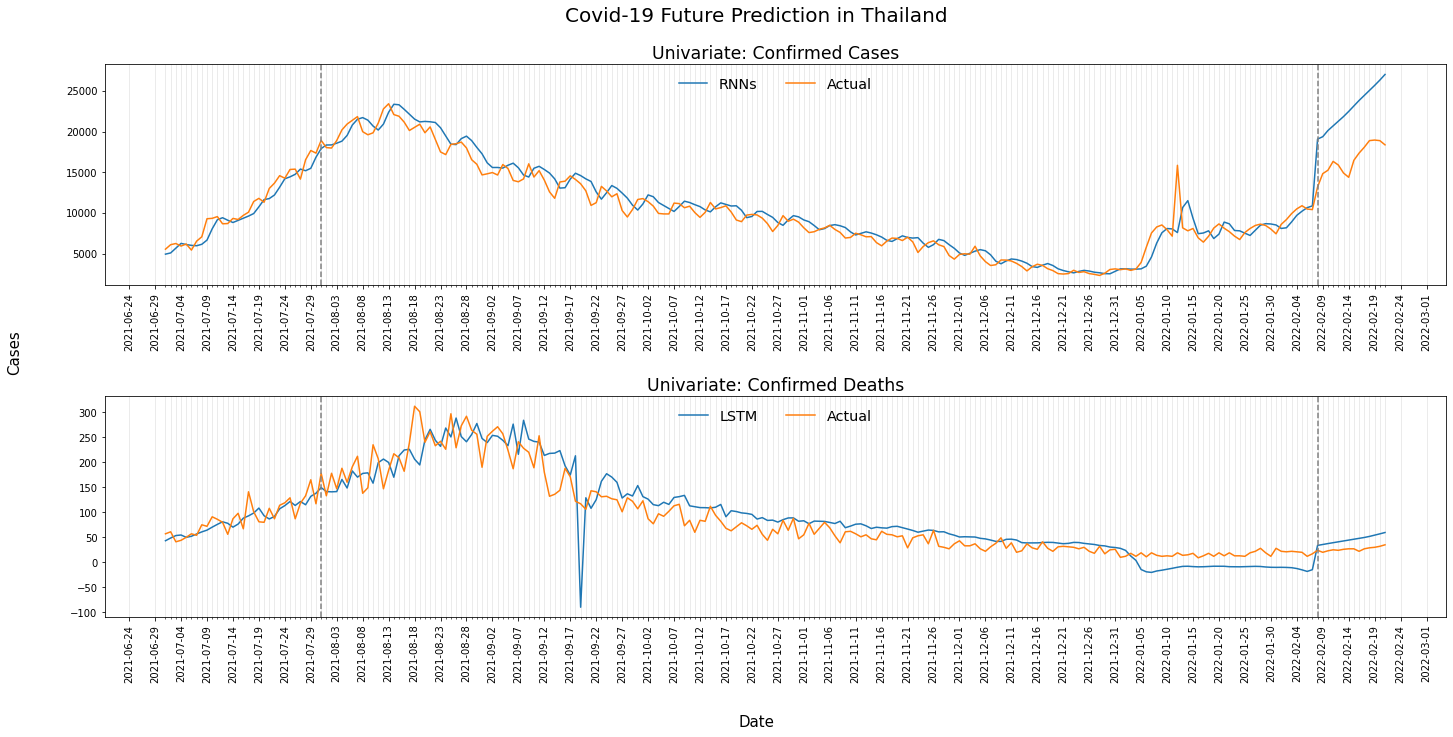

In [16]:

pred = pd.concat([uni_i_pred, 
                  uni_d_pred],
                 axis=1)
pred.columns = ['uni_i', 'uni_d']

start_date = infect.Date[0]

# extract actual data
act_i = data_i[(data_i['Date'] >= start_date)].reset_index(drop = True)
act_i = act_i[0:len(pred)]

act_d = data_d[(data_d['Date'] >= start_date)].reset_index(drop = True)
act_d = act_d[0:len(pred)]

pred = pd.concat([pred, act_i.Cases_daily2, act_d.Deaths_daily2, act_i.Date], axis = 1)

date_test = pred['Date'][0+index]
date_predict = pred['Date'][len(y_uni_i_total)]
tick_spacing = 5

fig, axes = plt.subplots(2, 1, figsize=(20,10)) 
fig.suptitle("Covid-19 Future Prediction in Thailand", fontsize=20)

# Univariate confirmed cases
axes[0].plot(pred['Date'], pred['uni_i'], label = uni_in)
axes[0].plot(pred['Date'], pred['Cases_daily2'], label = "Actual")
axes[0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0].set_title("Univariate: Confirmed Cases", fontsize = 'xx-large')
axes[0].tick_params('x',labelrotation=90)
axes[0].axvline(date_test, color="gray", linestyle="--")
axes[0].axvline(date_predict, color="gray", linestyle="--")
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0].set_xticks(pred['Date'], minor=True)
axes[0].xaxis.grid(True, which='both', alpha=0.3)


# Univariate confirmed deaths
axes[1].plot(pred['Date'],pred['uni_d'], label = uni_de)
axes[1].plot(pred['Date'], pred['Deaths_daily2'], label = "Actual")
axes[1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1].set_title("Univariate: Confirmed Deaths", fontsize = 'xx-large')
axes[1].tick_params('x',labelrotation=90)
axes[1].axvline(date_test, color="gray", linestyle="--")
axes[1].axvline(date_predict, color="gray", linestyle="--")
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1].set_xticks(pred['Date'], minor=True)
axes[1].xaxis.grid(True, which='both', alpha=0.3)



fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()

As showed in the graphs, 14-day ahead predictions for confirmed cases were relatively close to the actual average values of the target. In contrast, the confirmed deaths future predictions were lower than the actual values.


# Limitation

The first limitation was that we are unable to collect the actual cases in Thailand. Although, the JHU source was reliable, there were a few missing data that the report failed to capture which resulted in inaccurate predictions.

There were many other factors that we were unable to capture and use as our input. For instance, people's responses to governmental policies. These behaviors could directly affect trends of the cases in Thailand. 